# Configurações e treinamento da rede neural

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sagemaker
from sagemaker import get_execution_role

In [4]:
bucket = 'redeneural'
subpasta_dataset = 'mnist'
session = sagemaker.Session()
role = get_execution_role()
region = session.boto_session.region_name
base_treinamento = 's3://sagemaker-sample-data-{}/tensorflow/mnist'.format(region)
output_location = 's3://{}/{}/output-tf'.format(bucket, subpasta_dataset)
print('Localização da base de treinamento: ', base_treinamento)
print('Região:', region)
print('Localização do modelo:', output_location)

Localização da base de treinamento:  s3://sagemaker-sample-data-us-east-1/tensorflow/mnist
Região: us-east-1
Localização do modelo: s3://redeneural/mnist/output-tf


In [5]:
from sagemaker.tensorflow import TensorFlow
# para conectar o script criado com o tensorflow
mnist_tensor = TensorFlow(entry_point = "mnist.py",
                          role= role,
                          instance_count=1,
                          instance_type = 'ml.p3.2xlarge',
                          framework_version = '2.5',
                          py_version = 'py37',
                          output_path = output_location,
                          hyperparametrer = {'epochs': 20, 'batch_size': 128, 'learning-rate': 0.001, 'dropout': 1})

In [6]:
mnist_tensor.fit(base_treinamento)

2023-04-12 10:46:32 Starting - Starting the training job...
2023-04-12 10:47:00 Starting - Preparing the instances for trainingProfilerReport-1681296392: InProgress
......
2023-04-12 10:48:03 Downloading - Downloading input data...
2023-04-12 10:48:28 Training - Downloading the training image..................
2023-04-12 10:51:17 Training - Training image download completed. Training in progress...2023-04-12 10:51:38.688464: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2023-04-12 10:51:38.688695: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2023-04-12 10:51:38.694192: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-04-12 10:51:38.742304: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the 

In [13]:
!pygmentize mnist.py

# https://docs.aws.amazon.com/sagemaker/latest/dg/pre-built-containers-frameworks-deep-learning.html

# Paper dropout: https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf

import argparse
import json
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

if __name__ == "__main__":
    # https://docs.python.org/3/howto/argparse.html
    parser = argparse.ArgumentParser()
    
    # será passados os hiperparametros da redeneural
    parser.add_argument('--epochs', type=int, default=2)
    parser.add_argument('--learning-rate', type=float, default=0.001)
    parser.add_argument('--batch-size', type=int, default=32)
    parser.add_argument('--dropout', type=int)
    
     # PARAMETROS DA AMAZON
    
    # os.environ.get('') = extrair as configurações do sistema operacional
    
    # https://github.com/aws/sagemaker-training-toolkit/blob

# Deploy e previsões

In [7]:
classificador_mnist = mnist_tensor.deploy(initial_instance_count=1, instance_type = 'ml.p2.xlarge')

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


--------------!

In [8]:
# -- parametros
# cp para realizar a copia
!aws --region {region} s3 cp s3://sagemaker-sample-data-{region}/tensorflow/mnist/eval_data.npy eval_data.npy
!aws --region {region} s3 cp s3://sagemaker-sample-data-{region}/tensorflow/mnist/eval_labels.npy eval_labels.npy

download: s3://sagemaker-sample-data-us-east-1/tensorflow/mnist/eval_data.npy to ./eval_data.npy
download: s3://sagemaker-sample-data-us-east-1/tensorflow/mnist/eval_labels.npy to ./eval_labels.npy


In [9]:
X_teste = np.load('eval_data.npy')
y_teste = np.load('eval_labels.npy')

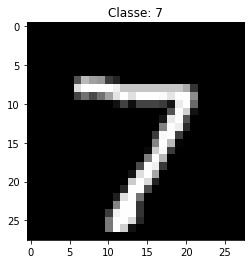

In [10]:
plt.imshow(X_teste[0].reshape(28,28), cmap='gray')
plt.title('Classe: ' + str(y_teste[0]))
plt.show()

In [11]:
previsao = classificador_mnist.predict(X_teste[0])
previsao

{'predictions': [[4.90927132e-10,
   1.59491401e-06,
   0.000132678906,
   4.18988384e-05,
   9.768443e-11,
   6.47187526e-10,
   4.21420971e-12,
   0.999823868,
   1.46458472e-08,
   1.60006799e-08]]}

In [12]:
# em formato de array
previsao = previsao['predictions']
previsao

[[4.90927132e-10,
  1.59491401e-06,
  0.000132678906,
  4.18988384e-05,
  9.768443e-11,
  6.47187526e-10,
  4.21420971e-12,
  0.999823868,
  1.46458472e-08,
  1.60006799e-08]]

In [13]:
np.argmax(previsao)

7